## Adaptive MCMC Methods

One of the main challenges in using MCMC methods like Metropolis-Hastings is choosing appropriate proposal distributions and step sizes. If the step size is too small, the chain explores the parameter space very slowly. If it's too large, most proposals are rejected and the chain doesn't move efficiently. **Adaptive MCMC** methods automatically tune the proposal distribution during the sampling process to improve efficiency.

### Why Adapt?

Standard Metropolis-Hastings requires manual tuning of:
- **Step sizes** (proposal variance) for each parameter
- **Proposal covariance** when parameters are correlated
- **Acceptance rate** (typically target 20-40% for optimal efficiency)

Adaptive methods eliminate this manual tuning by:
1. Learning optimal proposal parameters from the chain history
2. Automatically adjusting to the posterior's shape and scale
3. Handling correlated parameters through covariance adaptation

### Types of Adaptive MCMC

#### 1. Adaptive Metropolis (AM)

The **Adaptive Metropolis algorithm** (Haario et al., 2001) updates the proposal covariance based on the empirical covariance of all previous samples:

$$
\mathbf{C}_t = s_d \cdot \text{Cov}(\mathbf{x}^{(0)}, \mathbf{x}^{(1)}, \ldots, \mathbf{x}^{(t-1)}) + s_d \epsilon \mathbf{I}
$$

where:
- $\mathbf{C}_t$ is the proposal covariance at iteration $t$
- $s_d = (2.38)^2/d$ is a scaling factor (d = dimension)
- $\epsilon$ is a small constant to prevent singularity
- $\mathbf{I}$ is the identity matrix

**Algorithm:**
1. Run initial phase with fixed proposal (e.g., first $t_0 = 100$ iterations)
2. After $t_0$, compute empirical covariance from samples
3. Use this covariance (scaled) as the proposal distribution
4. Update covariance periodically (e.g., every 50 iterations)

**Advantages:**
- Automatically learns correlations between parameters
- Scales proposals appropriately for each dimension
- Proven to maintain ergodicity under certain conditions

**Limitations:**
- Requires many samples to estimate covariance reliably
- May adapt slowly in early iterations
- Not ideal for very high-dimensional problems

#### 2. Adaptive Metropolis-Within-Gibbs (AMWG)

Instead of adapting all parameters jointly, **AMWG** adapts each parameter individually by adjusting step sizes to achieve a target acceptance rate:

For each parameter $i$:
$$
\sigma_i^{(t+1)} = \sigma_i^{(t)} \cdot \exp\left(\gamma_t (a_i^{(t)} - a^*)\right)
$$

where:
- $\sigma_i^{(t)}$ is the step size for parameter $i$ at iteration $t$
- $\gamma_t$ is a decreasing adaptation rate (e.g., $\gamma_t = t^{-0.6}$)
- $a_i^{(t)}$ is the current acceptance rate for parameter $i$
- $a^*$ is the target acceptance rate (typically 0.44 for 1D, 0.234 for high-D)

**Algorithm:**
1. Maintain separate acceptance counters for each parameter
2. Update one parameter at a time (Gibbs-style)
3. After each update, adjust that parameter's step size
4. Gradually decrease adaptation rate to ensure convergence

**Advantages:**
- Simple to implement
- Works well when parameters are weakly correlated
- Robust for high-dimensional problems

**Limitations:**
- Doesn't learn parameter correlations
- Less efficient than AM when strong correlations exist

#### 3. Delayed Rejection Adaptive Metropolis (DRAM)

**DRAM** (Haario et al., 2006) combines two ideas:
1. **Delayed Rejection**: If a proposal is rejected, try again with a smaller step
2. **Adaptive Metropolis**: Learn proposal covariance from samples

**Delayed Rejection Steps:**
- First proposal: $\mathbf{x}' \sim q_1(\cdot|\mathbf{x}^{(t)})$ with covariance $\mathbf{C}_1$
- If rejected, second proposal: $\mathbf{x}'' \sim q_2(\cdot|\mathbf{x}^{(t)})$ with covariance $\mathbf{C}_2 = \gamma \mathbf{C}_1$ (where $\gamma < 1$)
- Acceptance probability for second stage accounts for the first rejection

**Advantages:**
- Higher acceptance rates than standard Metropolis
- More efficient exploration (makes progress even when first proposal fails)
- Combines benefits of adaptation and delayed rejection

**Practical Implementation:**
```
if first_proposal_rejected:
    make_second_proposal_with_smaller_stepsize()
    compute_corrected_acceptance_probability()
```

### Diminishing Adaptation (Vanishing Adaptation)

For theoretical validity, adaptive MCMC must satisfy the **vanishing adaptation condition**: the amount of adaptation must decrease over time so the chain eventually behaves like a standard MCMC.

Common approaches:
- **Decrease adaptation frequency**: Adapt every $n$ iterations, with $n$ increasing
- **Decrease adaptation magnitude**: Use $\gamma_t = t^{-\alpha}$ with $0.5 < \alpha \leq 1$
- **Stop adapting**: After sufficient samples (e.g., after 50% of run)

### Practical Guidelines

1. **Start with a burn-in period** (e.g., 10-20% of total) before adaptation begins
2. **Monitor convergence** using trace plots and diagnostics (Gelman-Rubin, effective sample size)
3. **Check acceptance rates**:
   - Too low (<10%): Proposals too far from current state
   - Too high (>80%): Proposals too conservative, slow exploration
   - Optimal: 20-40% depending on dimension
4. **Use multiple chains** to verify convergence and compare results
5. **Consider computational cost**: Adaptation overhead should be small compared to likelihood evaluations

### Software Implementations

- **Python**: `PyMC3`, `emcee` (ensemble sampler), `ptemcee` (parallel tempering)
- **R**: `adaptMCMC` package
- **MATLAB**: Custom implementations or `MCMC Toolbox`

### References

- Haario, H., Saksman, E., & Tamminen, J. (2001). An adaptive Metropolis algorithm. *Bernoulli*, 7(2), 223-242.
- Haario, H., Laine, M., Mira, A., & Saksman, E. (2006). DRAM: Efficient adaptive MCMC. *Statistics and Computing*, 16(4), 339-354.
- Roberts, G. O., & Rosenthal, J. S. (2009). Examples of adaptive MCMC. *Journal of Computational and Graphical Statistics*, 18(2), 349-367.
- Andrieu, C., & Thoms, J. (2008). A tutorial on adaptive MCMC. *Statistics and Computing*, 18(4), 343-373.

## Log-Decay Example: Adaptive Metropolis Implementation

This example demonstrates the Adaptive Metropolis (AM) algorithm applied to the same log-decay problem from the standard MCMC example. We'll compare how the adaptive approach automatically tunes the proposal covariance, eliminating the need for manual step size selection.

**Problem:** Estimate parameters $a$ and $t_R$ from noisy observations of $d = a \log(1 + t/t_R)$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg

# Metropolis acceptance function
def metropolis(g1, g2):
    """
    Metropolis acceptance criterion
    g1: log probability of current sample
    g2: log probability of proposed sample
    """
    rat = np.exp(g2 - g1)
    if rat > 1:
        accept = 1
    else:
        r = np.random.rand()
        if r < rat:
            accept = 1
        else:
            accept = 0
    return accept


# Make synthetic data assuming d = a*log(1+t/tR)
# where tR is relaxation time and t is time
a_true = 1.0
tR_true = 1.0

t = np.linspace(0, 60, 20)
d = a_true * np.log(1 + t/tR_true)

# Add Gaussian noise
np.random.seed(42)  # for reproducibility
d = d + 0.15 * np.random.randn(len(d))

# Error vector
sigma = 0.15 * np.ones(len(d))

print("Generated synthetic data")
print(f"True parameters: a = {a_true}, tR = {tR_true}")
print(f"Number of data points: {len(d)}")
print(f"Noise level (sigma): {sigma[0]:.3f}")

# Initial guess
X = np.array([1.0, 1.0])  # [a, tR]

# ADAPTIVE METROPOLIS PARAMETERS
NumSamples = int(1e4)
n_dim = len(X)  # number of parameters

# AM parameters
t0 = 500  # start adapting after this many iterations
sd = (2.38)**2 / n_dim  # scaling factor for optimal acceptance rate
epsilon = 1e-6  # small constant to prevent singularity

# Initial proposal covariance (identity scaled by initial variance)
initial_scale = 0.1
C_proposal = initial_scale**2 * np.eye(n_dim)

# Storage
M = np.zeros((n_dim, NumSamples))  # store samples
logprobs = np.zeros(NumSamples)
dhats = np.zeros((len(d), NumSamples))  # store all model predictions
accept_sample = 0  # track acceptance rate
C_history = []  # store covariance evolution

# Compute log probability for initial sample
a, tR = X
dhat = a * np.log(1 + t/tR)
resid = (d - dhat) / sigma
logprob = -0.5 * np.dot(resid, resid)

Xprev = X.copy()
logprobprev = logprob

print(f"\nStarting Adaptive Metropolis MCMC...")
print(f"Initial proposal covariance scale: {initial_scale}")
print(f"Adaptation starts at iteration: {t0}")

# Begin Adaptive Metropolis walk
for k in range(NumSamples):
    # ADAPTATION STEP: Update proposal covariance
    if k >= t0 and k > 0:
        # Compute empirical covariance from all samples so far
        samples_so_far = M[:, :k].T  # (k x n_dim)
        empirical_cov = np.cov(samples_so_far.T)
        
        # AM formula: C_t = sd * Cov(X_0, ..., X_{t-1}) + sd * epsilon * I
        C_proposal = sd * empirical_cov + sd * epsilon * np.eye(n_dim)
        
        # Store covariance for analysis (every 100 iterations)
        if k % 100 == 0:
            C_history.append((k, C_proposal.copy()))
    
    # PROPOSAL STEP: Generate candidate from multivariate normal
    # Draw from N(X_current, C_proposal)
    try:
        # Use Cholesky decomposition for numerical stability
        L = linalg.cholesky(C_proposal, lower=True)
        z = np.random.randn(n_dim)
        X_trial = X + L @ z
    except linalg.LinAlgError:
        # Fallback if covariance is not positive definite
        X_trial = X + np.random.multivariate_normal(np.zeros(n_dim), C_proposal)
    
    # EVALUATION STEP: Compute log probability of trial
    a, tR = X_trial
    
    # Check if parameters are physically reasonable
    if a <= 0 or tR <= 0:
        # Reject automatically
        accept = 0
        logprob2 = -np.inf
        dhat2 = dhat
    else:
        dhat2 = a * np.log(1 + t/tR)
        resid = (d - dhat2) / sigma
        logprob2 = -0.5 * np.dot(resid, resid)
        
        # ACCEPTANCE STEP: Metropolis rule
        accept = metropolis(logprob, logprob2)
    
    # UPDATE STEP
    if accept == 1:  # Accept: update to new state
        X = X_trial.copy()
        logprob = logprob2
        dhat = dhat2
        Xprev = X.copy()
        logprobprev = logprob
        accept_sample += 1
    else:  # Reject: stay at previous state
        X = Xprev.copy()
        logprob = logprobprev
    
    # STORAGE
    M[:, k] = X
    logprobs[k] = logprob
    dhats[:, k] = dhat

acceptance_rate = accept_sample / NumSamples
print(f"\nAdaptive Metropolis MCMC complete!")
print(f"Total acceptance rate: {acceptance_rate:.4f}")
print(f"Covariance adapted {len(C_history)} times")

# Calculate final statistics
burn_in = t0  # use adaptation start as burn-in
M_burned = M[:, burn_in:]

mean_a = np.mean(M_burned[0, :])
mean_tR = np.mean(M_burned[1, :])
std_a = np.std(M_burned[0, :], ddof=1)
std_tR = np.std(M_burned[1, :], ddof=1)

print(f"\nEstimated parameters (after burn-in of {burn_in} samples):")
print(f"  a:  {mean_a:.4f} ± {std_a:.4f}  (true: {a_true})")
print(f"  tR: {mean_tR:.4f} ± {std_tR:.4f}  (true: {tR_true})")

# Compute final empirical covariance
final_cov = np.cov(M_burned)
print(f"\nFinal empirical covariance matrix:")
print(final_cov)
print(f"\nCorrelation coefficient: {final_cov[0,1] / (std_a * std_tR):.4f}")

Generated synthetic data
True parameters: a = 1.0, tR = 1.0
Number of data points: 20
Noise level (sigma): 0.150

Starting Adaptive Metropolis MCMC...
Initial proposal covariance scale: 0.1
Adaptation starts at iteration: 500

Adaptive Metropolis MCMC complete!
Total acceptance rate: 0.3072
Covariance adapted 95 times

Estimated parameters (after burn-in of 500 samples):
  a:  0.8863 ± 0.0534  (true: 1.0)
  tR: 0.6788 ± 0.1584  (true: 1.0)

Final empirical covariance matrix:
[[0.00285579 0.00831911]
 [0.00831911 0.0251033 ]]

Correlation coefficient: 0.9825


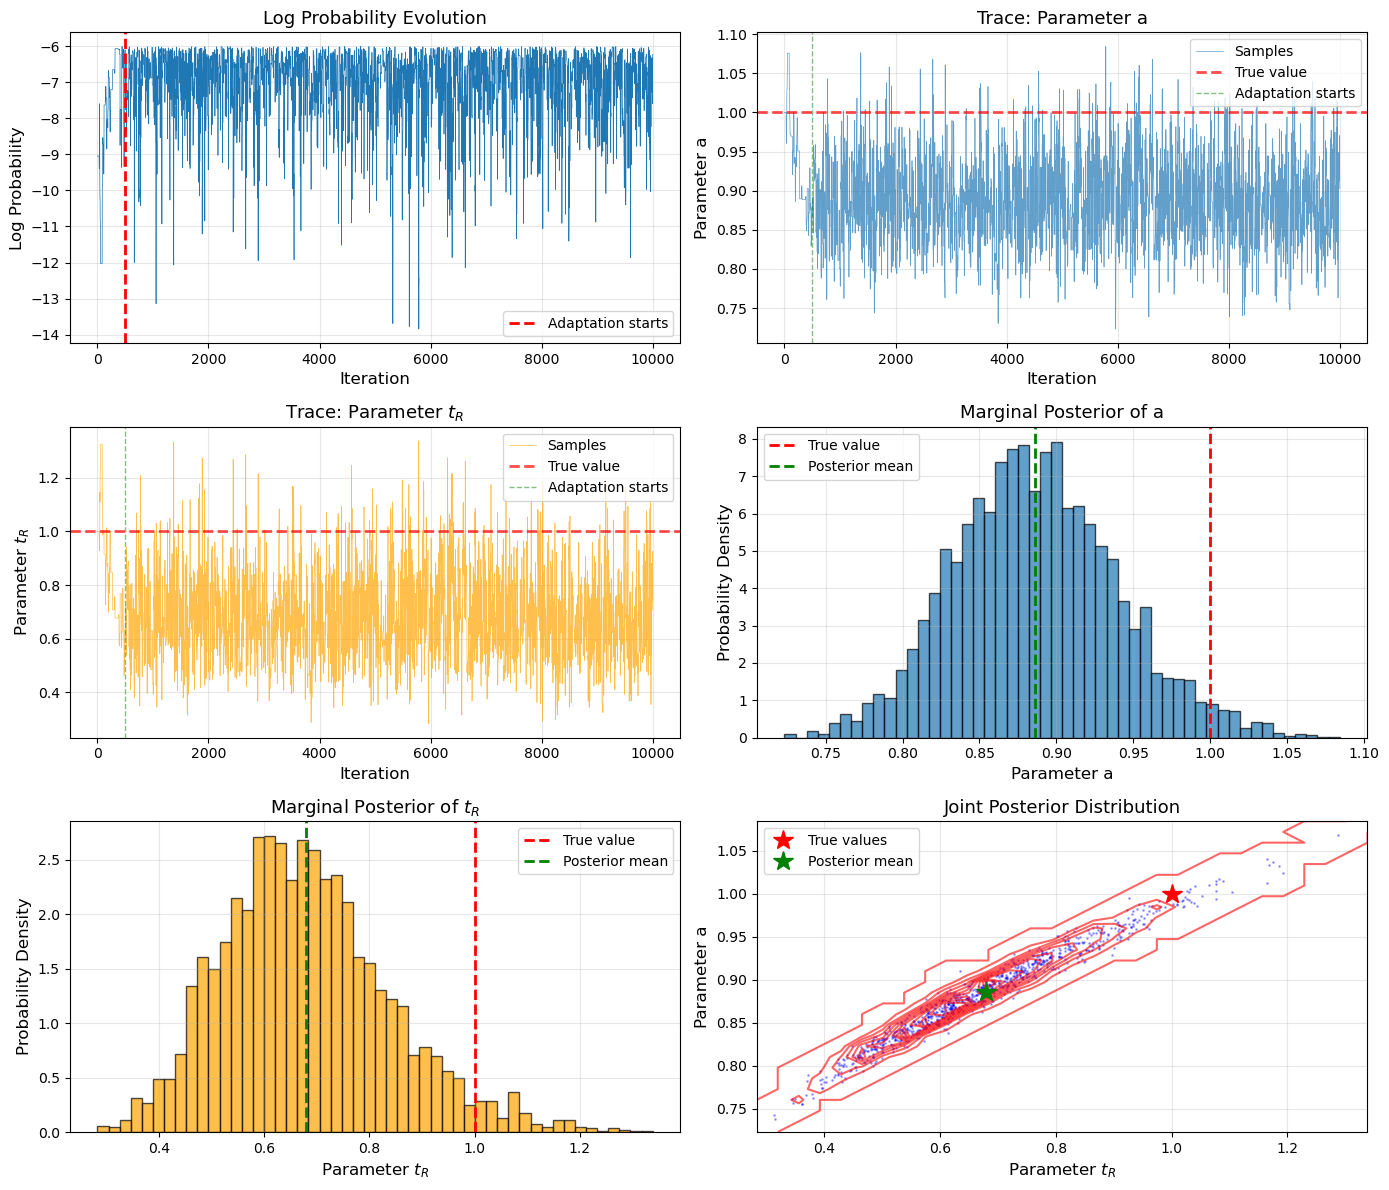

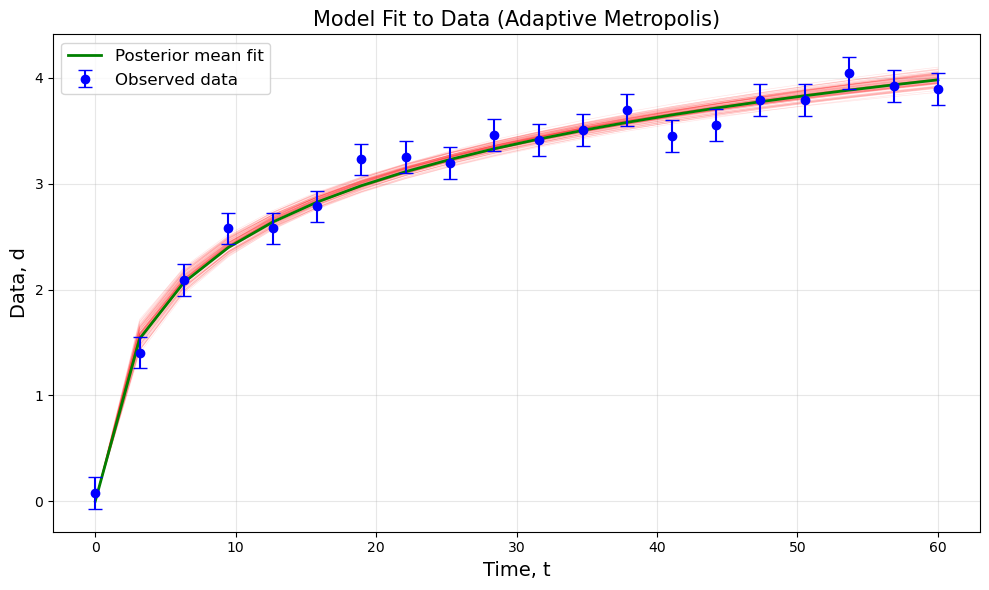


Plots generated successfully!


In [2]:
# Visualization: Compare adaptive and non-adaptive behavior

fig, axes = plt.subplots(3, 2, figsize=(14, 12))

# Plot 1: Log probability evolution
ax1 = axes[0, 0]
ax1.plot(logprobs, linewidth=0.5)
ax1.axvline(x=t0, color='r', linestyle='--', linewidth=2, label='Adaptation starts')
ax1.set_xlabel('Iteration', fontsize=12)
ax1.set_ylabel('Log Probability', fontsize=12)
ax1.set_title('Log Probability Evolution', fontsize=13)
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Parameter traces
ax2 = axes[0, 1]
ax2.plot(M[0, :], linewidth=0.5, alpha=0.7, label='a')
ax2.axhline(y=a_true, color='r', linestyle='--', linewidth=2, alpha=0.7)
ax2.axvline(x=t0, color='g', linestyle='--', linewidth=1, alpha=0.5)
ax2.set_xlabel('Iteration', fontsize=12)
ax2.set_ylabel('Parameter a', fontsize=12)
ax2.set_title('Trace: Parameter a', fontsize=13)
ax2.legend(['Samples', 'True value', 'Adaptation starts'])
ax2.grid(True, alpha=0.3)

ax3 = axes[1, 0]
ax3.plot(M[1, :], linewidth=0.5, alpha=0.7, color='orange', label='tR')
ax3.axhline(y=tR_true, color='r', linestyle='--', linewidth=2, alpha=0.7)
ax3.axvline(x=t0, color='g', linestyle='--', linewidth=1, alpha=0.5)
ax3.set_xlabel('Iteration', fontsize=12)
ax3.set_ylabel('Parameter $t_R$', fontsize=12)
ax3.set_title('Trace: Parameter $t_R$', fontsize=13)
ax3.legend(['Samples', 'True value', 'Adaptation starts'])
ax3.grid(True, alpha=0.3)

# Plot 3: Marginal posterior distributions
ax4 = axes[1, 1]
ax4.hist(M_burned[0, :], bins=50, density=True, alpha=0.7, edgecolor='black')
ax4.axvline(x=a_true, color='r', linestyle='--', linewidth=2, label='True value')
ax4.axvline(x=mean_a, color='g', linestyle='--', linewidth=2, label='Posterior mean')
ax4.set_xlabel('Parameter a', fontsize=12)
ax4.set_ylabel('Probability Density', fontsize=12)
ax4.set_title('Marginal Posterior of a', fontsize=13)
ax4.legend()
ax4.grid(True, alpha=0.3)

ax5 = axes[2, 0]
ax5.hist(M_burned[1, :], bins=50, density=True, alpha=0.7, edgecolor='black', color='orange')
ax5.axvline(x=tR_true, color='r', linestyle='--', linewidth=2, label='True value')
ax5.axvline(x=mean_tR, color='g', linestyle='--', linewidth=2, label='Posterior mean')
ax5.set_xlabel('Parameter $t_R$', fontsize=12)
ax5.set_ylabel('Probability Density', fontsize=12)
ax5.set_title('Marginal Posterior of $t_R$', fontsize=13)
ax5.legend()
ax5.grid(True, alpha=0.3)

# Plot 4: Joint posterior (2D scatter with contours)
ax6 = axes[2, 1]
# Scatter plot of samples
ax6.scatter(M_burned[1, ::10], M_burned[0, ::10], s=1, alpha=0.3, c='blue')
# Add 2D histogram contours
H, xedges, yedges = np.histogram2d(M_burned[1, :], M_burned[0, :], bins=30)
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
ax6.contour(H.T, extent=extent, levels=10, colors='red', linewidths=1.5, alpha=0.6)
ax6.plot(tR_true, a_true, 'r*', markersize=15, label='True values')
ax6.plot(mean_tR, mean_a, 'g*', markersize=15, label='Posterior mean')
ax6.set_xlabel('Parameter $t_R$', fontsize=12)
ax6.set_ylabel('Parameter a', fontsize=12)
ax6.set_title('Joint Posterior Distribution', fontsize=13)
ax6.legend()
ax6.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Plot fit to data
fig, ax = plt.subplots(figsize=(10, 6))
# Plot subset of model predictions (every 100th sample from burned-in samples)
for i in range(burn_in, NumSamples, 100):
    ax.plot(t, dhats[:, i], 'r-', alpha=0.1, linewidth=0.5)
# Plot best fit (using posterior mean)
best_fit = mean_a * np.log(1 + t/mean_tR)
ax.plot(t, best_fit, 'g-', linewidth=2, label='Posterior mean fit')
# Plot data with error bars
ax.errorbar(t, d, yerr=sigma, fmt='bo', capsize=5, markersize=6, label='Observed data')
ax.set_xlabel('Time, t', fontsize=14)
ax.set_ylabel('Data, d', fontsize=14)
ax.set_title('Model Fit to Data (Adaptive Metropolis)', fontsize=15)
ax.legend(fontsize=12)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("\nPlots generated successfully!")

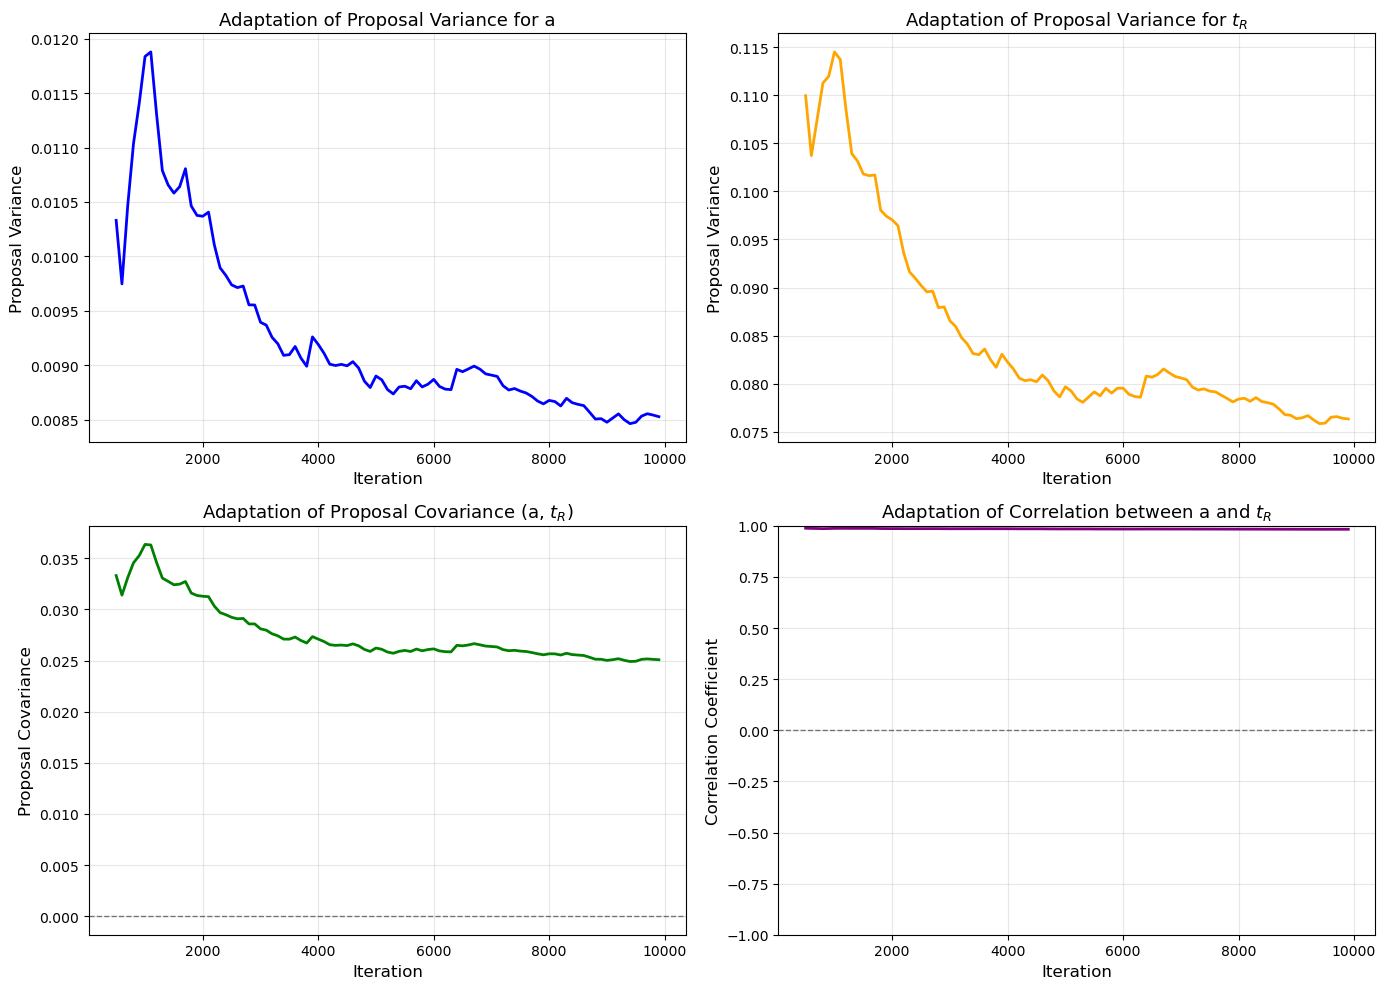


Covariance Adaptation Analysis:
Initial proposal variance (a):  0.010000
Final proposal variance (a):    0.008529
Initial proposal variance (tR): 0.010000
Final proposal variance (tR):   0.076314
Final covariance (a, tR):       0.025082
Final correlation coefficient:  0.9831

Empirical covariance from posterior samples:
Variance (a):     0.002856
Variance (tR):    0.025103
Covariance:       0.008319


In [3]:
# Analyze how the proposal covariance adapted over time

if len(C_history) > 0:
    # Extract covariance evolution
    iterations = [item[0] for item in C_history]
    var_a = [item[1][0, 0] for item in C_history]  # variance of a
    var_tR = [item[1][1, 1] for item in C_history]  # variance of tR
    cov_a_tR = [item[1][0, 1] for item in C_history]  # covariance between a and tR
    
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    # Plot 1: Variance evolution for parameter a
    ax1 = axes[0, 0]
    ax1.plot(iterations, var_a, 'b-', linewidth=2)
    ax1.set_xlabel('Iteration', fontsize=12)
    ax1.set_ylabel('Proposal Variance', fontsize=12)
    ax1.set_title('Adaptation of Proposal Variance for a', fontsize=13)
    ax1.grid(True, alpha=0.3)
    
    # Plot 2: Variance evolution for parameter tR
    ax2 = axes[0, 1]
    ax2.plot(iterations, var_tR, 'orange', linewidth=2)
    ax2.set_xlabel('Iteration', fontsize=12)
    ax2.set_ylabel('Proposal Variance', fontsize=12)
    ax2.set_title('Adaptation of Proposal Variance for $t_R$', fontsize=13)
    ax2.grid(True, alpha=0.3)
    
    # Plot 3: Covariance evolution
    ax3 = axes[1, 0]
    ax3.plot(iterations, cov_a_tR, 'g-', linewidth=2)
    ax3.axhline(y=0, color='k', linestyle='--', linewidth=1, alpha=0.5)
    ax3.set_xlabel('Iteration', fontsize=12)
    ax3.set_ylabel('Proposal Covariance', fontsize=12)
    ax3.set_title('Adaptation of Proposal Covariance (a, $t_R$)', fontsize=13)
    ax3.grid(True, alpha=0.3)
    
    # Plot 4: Correlation coefficient evolution
    ax4 = axes[1, 1]
    correlation = [cov_a_tR[i] / np.sqrt(var_a[i] * var_tR[i]) 
                   if var_a[i] > 0 and var_tR[i] > 0 else 0 
                   for i in range(len(iterations))]
    ax4.plot(iterations, correlation, 'purple', linewidth=2)
    ax4.axhline(y=0, color='k', linestyle='--', linewidth=1, alpha=0.5)
    ax4.set_xlabel('Iteration', fontsize=12)
    ax4.set_ylabel('Correlation Coefficient', fontsize=12)
    ax4.set_title('Adaptation of Correlation between a and $t_R$', fontsize=13)
    ax4.set_ylim([-1, 1])
    ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print("\nCovariance Adaptation Analysis:")
    print(f"Initial proposal variance (a):  {initial_scale**2:.6f}")
    print(f"Final proposal variance (a):    {var_a[-1]:.6f}")
    print(f"Initial proposal variance (tR): {initial_scale**2:.6f}")
    print(f"Final proposal variance (tR):   {var_tR[-1]:.6f}")
    print(f"Final covariance (a, tR):       {cov_a_tR[-1]:.6f}")
    print(f"Final correlation coefficient:  {correlation[-1]:.4f}")
    
    # Compare with empirical covariance from samples
    print(f"\nEmpirical covariance from posterior samples:")
    print(f"Variance (a):     {final_cov[0, 0]:.6f}")
    print(f"Variance (tR):    {final_cov[1, 1]:.6f}")
    print(f"Covariance:       {final_cov[0, 1]:.6f}")
else:
    print("No covariance history recorded (NumSamples may be too small)")

### Key Observations: Adaptive Metropolis vs Standard Metropolis

**Advantages of Adaptive Metropolis:**

1. **Automatic Tuning**: No need to manually select step sizes for each parameter. The algorithm learns the optimal proposal distribution from the samples.

2. **Handles Correlation**: The covariance matrix automatically captures correlations between parameters (a and $t_R$ in this case), making proposals more efficient.

3. **Scale Adaptation**: Each parameter's proposal variance adapts to match the posterior distribution's scale, ensuring efficient exploration regardless of parameter magnitude differences.

4. **Improved Mixing**: After the adaptation phase, the chain typically mixes better (explores the posterior more efficiently) compared to a poorly-tuned standard Metropolis.

**Trade-offs:**

1. **Burn-in Period**: Need sufficient samples (typically 500-1000) before adaptation begins to get reliable covariance estimates.

2. **Computational Cost**: Computing the empirical covariance at each iteration adds overhead, though this is usually negligible compared to likelihood evaluations.

3. **Memory**: Storing all samples for covariance computation requires more memory (can be mitigated with windowed estimation).

**Theoretical Considerations:**

The AM algorithm maintains ergodicity (theoretical guarantee of convergence) by using the empirical covariance from all previous samples. The scaling factor $s_d = (2.38)^2/d$ is theoretically optimal for Gaussian targets, yielding acceptance rates around 23% for high dimensions.

**Practical Tips:**

- Start adaptation after a reasonable burn-in (e.g., 5-10% of total samples)
- Monitor the covariance evolution to ensure it stabilizes
- For very high-dimensional problems, consider windowed or componentwise adaptive methods
- The acceptance rate should settle around 20-40% for good performance

## Direct Comparison: Adaptive vs Non-Adaptive Metropolis

Let's run both methods on the same data and compare their performance using several metrics:
- **Acceptance rate**: Should be similar for well-tuned methods
- **Effective Sample Size (ESS)**: Higher is better - measures independent samples
- **Autocorrelation**: Lower is better - indicates faster mixing
- **Parameter estimation accuracy**: Both should recover true values
- **Computational efficiency**: Samples per unit autocorrelation time

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg

def compute_ess(samples):
    """
    Compute Effective Sample Size using autocorrelation
    """
    n = len(samples)
    mean = np.mean(samples)
    var = np.var(samples, ddof=1)
    
    if var == 0:
        return n
    
    # Compute autocorrelation
    max_lag = min(n // 2, 1000)
    autocorr = np.zeros(max_lag)
    
    for lag in range(max_lag):
        if lag == 0:
            autocorr[lag] = 1.0
        else:
            cov = np.mean((samples[:-lag] - mean) * (samples[lag:] - mean))
            autocorr[lag] = cov / var
    
    # Find first negative autocorr or use cutoff
    cutoff = max_lag
    for i in range(1, max_lag):
        if autocorr[i] < 0:
            cutoff = i
            break
    
    # ESS formula
    tau = 1 + 2 * np.sum(autocorr[1:cutoff])
    ess = n / tau
    
    return ess, autocorr[:cutoff]


def run_standard_metropolis(d, t, sigma, NumSamples, stepsize):
    """
    Run standard (non-adaptive) Metropolis-Hastings
    """
    n_dim = 2
    X = np.array([1.0, 1.0])
    
    # Storage
    M = np.zeros((n_dim, NumSamples))
    logprobs = np.zeros(NumSamples)
    accept_sample = 0
    
    # Initial evaluation
    a, tR = X
    dhat = a * np.log(1 + t/tR)
    resid = (d - dhat) / sigma
    logprob = -0.5 * np.dot(resid, resid)
    
    Xprev = X.copy()
    logprobprev = logprob
    
    # MCMC loop
    for k in range(NumSamples):
        # Fixed step size proposal
        r = (-1)**np.round(np.random.rand(n_dim)) * np.random.rand(n_dim)
        r = r * stepsize
        X_trial = X + r
        
        a, tR = X_trial
        
        # Check bounds
        if a <= 0 or tR <= 0:
            accept = 0
            logprob2 = -np.inf
        else:
            dhat2 = a * np.log(1 + t/tR)
            resid = (d - dhat2) / sigma
            logprob2 = -0.5 * np.dot(resid, resid)
            
            # Metropolis acceptance
            rat = np.exp(logprob2 - logprob)
            if rat > 1:
                accept = 1
            else:
                accept = 1 if np.random.rand() < rat else 0
        
        if accept == 1:
            X = X_trial.copy()
            logprob = logprob2
            Xprev = X.copy()
            logprobprev = logprob
            accept_sample += 1
        else:
            X = Xprev.copy()
            logprob = logprobprev
        
        M[:, k] = X
        logprobs[k] = logprob
    
    return M, logprobs, accept_sample / NumSamples


def run_adaptive_metropolis(d, t, sigma, NumSamples, t0, sd, epsilon, initial_scale):
    """
    Run Adaptive Metropolis
    """
    n_dim = 2
    X = np.array([1.0, 1.0])
    
    # Initial proposal covariance
    C_proposal = initial_scale**2 * np.eye(n_dim)
    
    # Storage
    M = np.zeros((n_dim, NumSamples))
    logprobs = np.zeros(NumSamples)
    accept_sample = 0
    
    # Initial evaluation
    a, tR = X
    dhat = a * np.log(1 + t/tR)
    resid = (d - dhat) / sigma
    logprob = -0.5 * np.dot(resid, resid)
    
    Xprev = X.copy()
    logprobprev = logprob
    
    # MCMC loop
    for k in range(NumSamples):
        # Adaptation
        if k >= t0 and k > 0:
            samples_so_far = M[:, :k].T
            empirical_cov = np.cov(samples_so_far.T)
            C_proposal = sd * empirical_cov + sd * epsilon * np.eye(n_dim)
        
        # Proposal
        try:
            L = linalg.cholesky(C_proposal, lower=True)
            z = np.random.randn(n_dim)
            X_trial = X + L @ z
        except linalg.LinAlgError:
            X_trial = X + np.random.multivariate_normal(np.zeros(n_dim), C_proposal)
        
        a, tR = X_trial
        
        # Check bounds
        if a <= 0 or tR <= 0:
            accept = 0
            logprob2 = -np.inf
        else:
            dhat2 = a * np.log(1 + t/tR)
            resid = (d - dhat2) / sigma
            logprob2 = -0.5 * np.dot(resid, resid)
            
            # Metropolis acceptance
            rat = np.exp(logprob2 - logprob)
            if rat > 1:
                accept = 1
            else:
                accept = 1 if np.random.rand() < rat else 0
        
        if accept == 1:
            X = X_trial.copy()
            logprob = logprob2
            Xprev = X.copy()
            logprobprev = logprob
            accept_sample += 1
        else:
            X = Xprev.copy()
            logprob = logprobprev
        
        M[:, k] = X
        logprobs[k] = logprob
    
    return M, logprobs, accept_sample / NumSamples


# Use the same data from before
print("Running comparison with same synthetic data...")
print(f"True parameters: a = {a_true}, tR = {tR_true}")

# Parameters for comparison
NumSamples_comp = 10000
np.random.seed(123)  # For reproducibility

# Standard Metropolis with manually tuned step size
stepsize_standard = np.array([0.05, 0.05])
print("\n" + "="*60)
print("Running STANDARD Metropolis-Hastings...")
M_standard, logprobs_standard, accept_rate_standard = run_standard_metropolis(
    d, t, sigma, NumSamples_comp, stepsize_standard
)
print(f"Acceptance rate: {accept_rate_standard:.4f}")

# Adaptive Metropolis
t0_adaptive = 500
sd_adaptive = (2.38)**2 / 2
epsilon_adaptive = 1e-6
initial_scale_adaptive = 0.1
print("\n" + "="*60)
print("Running ADAPTIVE Metropolis...")
M_adaptive, logprobs_adaptive, accept_rate_adaptive = run_adaptive_metropolis(
    d, t, sigma, NumSamples_comp, t0_adaptive, sd_adaptive, 
    epsilon_adaptive, initial_scale_adaptive
)
print(f"Acceptance rate: {accept_rate_adaptive:.4f}")

# Compute statistics (using burn-in)
burn_in_comp = 1000

# Standard method
M_std_burned = M_standard[:, burn_in_comp:]
mean_a_std = np.mean(M_std_burned[0, :])
mean_tR_std = np.mean(M_std_burned[1, :])
std_a_std = np.std(M_std_burned[0, :], ddof=1)
std_tR_std = np.std(M_std_burned[1, :], ddof=1)

# Adaptive method
M_adp_burned = M_adaptive[:, burn_in_comp:]
mean_a_adp = np.mean(M_adp_burned[0, :])
mean_tR_adp = np.mean(M_adp_burned[1, :])
std_a_adp = np.std(M_adp_burned[0, :], ddof=1)
std_tR_adp = np.std(M_adp_burned[1, :], ddof=1)

# Compute ESS
ess_a_std, autocorr_a_std = compute_ess(M_std_burned[0, :])
ess_tR_std, autocorr_tR_std = compute_ess(M_std_burned[1, :])
ess_a_adp, autocorr_a_adp = compute_ess(M_adp_burned[0, :])
ess_tR_adp, autocorr_tR_adp = compute_ess(M_adp_burned[1, :])

print("\n" + "="*60)
print("COMPARISON RESULTS")
print("="*60)
print("\nParameter Estimates:")
print(f"{'Method':<20} {'a (mean±std)':<25} {'tR (mean±std)':<25}")
print("-"*70)
print(f"{'True values':<20} {a_true:<25} {tR_true:<25}")
print(f"{'Standard':<20} {mean_a_std:.4f}±{std_a_std:.4f}           {mean_tR_std:.4f}±{std_tR_std:.4f}")
print(f"{'Adaptive':<20} {mean_a_adp:.4f}±{std_a_adp:.4f}           {mean_tR_adp:.4f}±{std_tR_adp:.4f}")

print("\n" + "="*60)
print("Efficiency Metrics:")
print(f"{'Method':<20} {'Accept Rate':<15} {'ESS (a)':<15} {'ESS (tR)':<15}")
print("-"*70)
print(f"{'Standard':<20} {accept_rate_standard:<15.4f} {ess_a_std:<15.1f} {ess_tR_std:<15.1f}")
print(f"{'Adaptive':<20} {accept_rate_adaptive:<15.4f} {ess_a_adp:<15.1f} {ess_tR_adp:<15.1f}")

# Efficiency gain
ess_gain_a = (ess_a_adp / ess_a_std - 1) * 100
ess_gain_tR = (ess_tR_adp / ess_tR_std - 1) * 100
print("\n" + "="*60)
print(f"Efficiency gain (Adaptive vs Standard):")
print(f"  Parameter a:  {ess_gain_a:+.1f}%")
print(f"  Parameter tR: {ess_gain_tR:+.1f}%")
print("="*60)

Running comparison with same synthetic data...
True parameters: a = 1.0, tR = 1.0

Running STANDARD Metropolis-Hastings...
Acceptance rate: 0.2799

Running ADAPTIVE Metropolis...
Acceptance rate: 0.3121

COMPARISON RESULTS

Parameter Estimates:
Method               a (mean±std)              tR (mean±std)            
----------------------------------------------------------------------
True values          1.0                       1.0                      
Standard             0.9045±0.0618           0.7376±0.1862
Adaptive             0.8847±0.0555           0.6750±0.1624

Efficiency Metrics:
Method               Accept Rate     ESS (a)         ESS (tR)       
----------------------------------------------------------------------
Standard             0.2799          24.0            22.7           
Adaptive             0.3121          845.7           818.9          

Efficiency gain (Adaptive vs Standard):
  Parameter a:  +3420.0%
  Parameter tR: +3505.4%


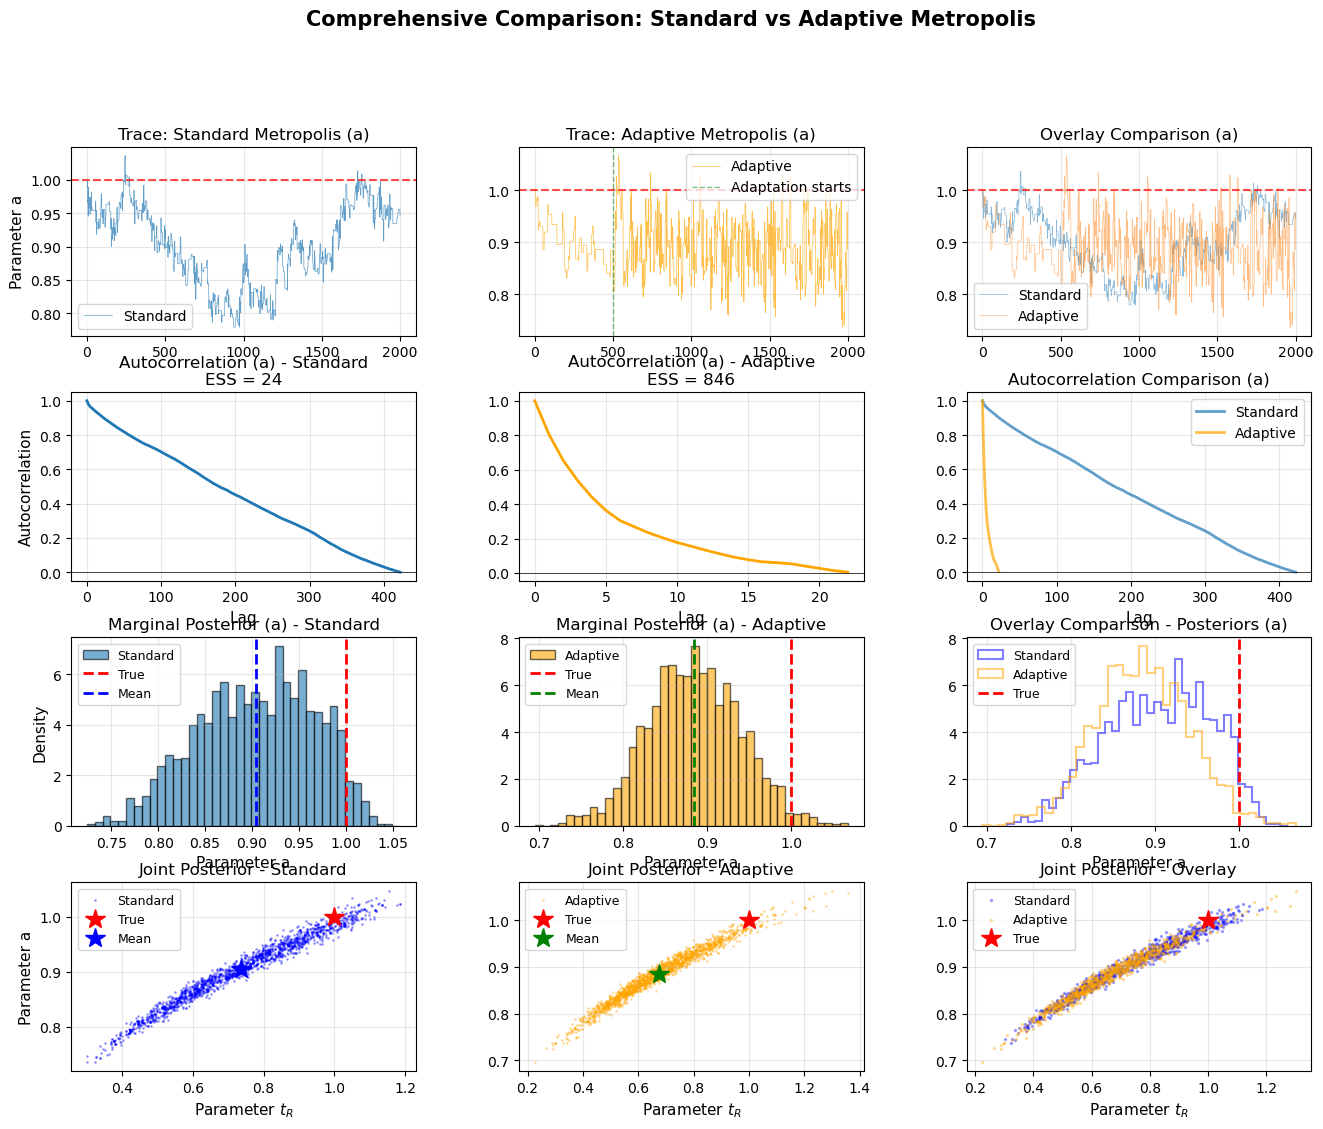


Visualization complete!


In [6]:
# Comprehensive visual comparison

fig = plt.figure(figsize=(16, 12))
gs = fig.add_gridspec(4, 3, hspace=0.3, wspace=0.3)

# Row 1: Trace plots
ax1 = fig.add_subplot(gs[0, 0])
ax1.plot(M_standard[0, :2000], linewidth=0.5, alpha=0.7, label='Standard')
ax1.axhline(y=a_true, color='r', linestyle='--', linewidth=1.5, alpha=0.7)
ax1.set_ylabel('Parameter a', fontsize=11)
ax1.set_title('Trace: Standard Metropolis (a)', fontsize=12)
ax1.legend()
ax1.grid(True, alpha=0.3)

ax2 = fig.add_subplot(gs[0, 1])
ax2.plot(M_adaptive[0, :2000], linewidth=0.5, alpha=0.7, color='orange', label='Adaptive')
ax2.axhline(y=a_true, color='r', linestyle='--', linewidth=1.5, alpha=0.7)
ax2.axvline(x=t0_adaptive, color='g', linestyle='--', linewidth=1, alpha=0.5, label='Adaptation starts')
ax2.set_title('Trace: Adaptive Metropolis (a)', fontsize=12)
ax2.legend()
ax2.grid(True, alpha=0.3)

ax3 = fig.add_subplot(gs[0, 2])
ax3.plot(M_standard[0, :2000], linewidth=0.5, alpha=0.5, label='Standard')
ax3.plot(M_adaptive[0, :2000], linewidth=0.5, alpha=0.5, label='Adaptive')
ax3.axhline(y=a_true, color='r', linestyle='--', linewidth=1.5, alpha=0.7)
ax3.set_title('Overlay Comparison (a)', fontsize=12)
ax3.legend()
ax3.grid(True, alpha=0.3)

# Row 2: Autocorrelation
ax4 = fig.add_subplot(gs[1, 0])
lags_std = np.arange(len(autocorr_a_std))
ax4.plot(lags_std, autocorr_a_std, linewidth=2, label='Standard')
ax4.axhline(y=0, color='k', linestyle='-', linewidth=0.5)
ax4.set_xlabel('Lag', fontsize=11)
ax4.set_ylabel('Autocorrelation', fontsize=11)
ax4.set_title(f'Autocorrelation (a) - Standard\nESS = {ess_a_std:.0f}', fontsize=12)
ax4.grid(True, alpha=0.3)

ax5 = fig.add_subplot(gs[1, 1])
lags_adp = np.arange(len(autocorr_a_adp))
ax5.plot(lags_adp, autocorr_a_adp, linewidth=2, color='orange', label='Adaptive')
ax5.axhline(y=0, color='k', linestyle='-', linewidth=0.5)
ax5.set_xlabel('Lag', fontsize=11)
ax5.set_title(f'Autocorrelation (a) - Adaptive\nESS = {ess_a_adp:.0f}', fontsize=12)
ax5.grid(True, alpha=0.3)

ax6 = fig.add_subplot(gs[1, 2])
ax6.plot(lags_std, autocorr_a_std, linewidth=2, label='Standard', alpha=0.7)
ax6.plot(lags_adp[:len(lags_std)], autocorr_a_adp[:len(lags_std)], 
         linewidth=2, color='orange', label='Adaptive', alpha=0.7)
ax6.axhline(y=0, color='k', linestyle='-', linewidth=0.5)
ax6.set_xlabel('Lag', fontsize=11)
ax6.set_title('Autocorrelation Comparison (a)', fontsize=12)
ax6.legend()
ax6.grid(True, alpha=0.3)

# Row 3: Marginal posteriors
ax7 = fig.add_subplot(gs[2, 0])
ax7.hist(M_std_burned[0, :], bins=40, density=True, alpha=0.6, 
         edgecolor='black', label='Standard')
ax7.axvline(x=a_true, color='r', linestyle='--', linewidth=2, label='True')
ax7.axvline(x=mean_a_std, color='b', linestyle='--', linewidth=2, label='Mean')
ax7.set_xlabel('Parameter a', fontsize=11)
ax7.set_ylabel('Density', fontsize=11)
ax7.set_title('Marginal Posterior (a) - Standard', fontsize=12)
ax7.legend(fontsize=9)
ax7.grid(True, alpha=0.3)

ax8 = fig.add_subplot(gs[2, 1])
ax8.hist(M_adp_burned[0, :], bins=40, density=True, alpha=0.6, 
         edgecolor='black', color='orange', label='Adaptive')
ax8.axvline(x=a_true, color='r', linestyle='--', linewidth=2, label='True')
ax8.axvline(x=mean_a_adp, color='g', linestyle='--', linewidth=2, label='Mean')
ax8.set_xlabel('Parameter a', fontsize=11)
ax8.set_title('Marginal Posterior (a) - Adaptive', fontsize=12)
ax8.legend(fontsize=9)
ax8.grid(True, alpha=0.3)

ax9 = fig.add_subplot(gs[2, 2])
ax9.hist(M_std_burned[0, :], bins=40, density=True, alpha=0.5, 
         edgecolor='blue', linewidth=1.5, histtype='step', label='Standard')
ax9.hist(M_adp_burned[0, :], bins=40, density=True, alpha=0.5, 
         edgecolor='orange', linewidth=1.5, histtype='step', label='Adaptive')
ax9.axvline(x=a_true, color='r', linestyle='--', linewidth=2, label='True')
ax9.set_xlabel('Parameter a', fontsize=11)
ax9.set_title('Overlay Comparison - Posteriors (a)', fontsize=12)
ax9.legend(fontsize=9)
ax9.grid(True, alpha=0.3)

# Row 4: Joint posteriors
ax10 = fig.add_subplot(gs[3, 0])
ax10.scatter(M_std_burned[1, ::5], M_std_burned[0, ::5], 
            s=1, alpha=0.3, c='blue', label='Standard')
ax10.plot(tR_true, a_true, 'r*', markersize=15, label='True', zorder=5)
ax10.plot(mean_tR_std, mean_a_std, 'b*', markersize=15, label='Mean', zorder=5)
ax10.set_xlabel('Parameter $t_R$', fontsize=11)
ax10.set_ylabel('Parameter a', fontsize=11)
ax10.set_title('Joint Posterior - Standard', fontsize=12)
ax10.legend(fontsize=9)
ax10.grid(True, alpha=0.3)

ax11 = fig.add_subplot(gs[3, 1])
ax11.scatter(M_adp_burned[1, ::5], M_adp_burned[0, ::5], 
            s=1, alpha=0.3, c='orange', label='Adaptive')
ax11.plot(tR_true, a_true, 'r*', markersize=15, label='True', zorder=5)
ax11.plot(mean_tR_adp, mean_a_adp, 'g*', markersize=15, label='Mean', zorder=5)
ax11.set_xlabel('Parameter $t_R$', fontsize=11)
ax11.set_title('Joint Posterior - Adaptive', fontsize=12)
ax11.legend(fontsize=9)
ax11.grid(True, alpha=0.3)

ax12 = fig.add_subplot(gs[3, 2])
ax12.scatter(M_std_burned[1, ::10], M_std_burned[0, ::10], 
            s=2, alpha=0.3, c='blue', label='Standard')
ax12.scatter(M_adp_burned[1, ::10], M_adp_burned[0, ::10], 
            s=2, alpha=0.3, c='orange', label='Adaptive')
ax12.plot(tR_true, a_true, 'r*', markersize=15, label='True', zorder=5)
ax12.set_xlabel('Parameter $t_R$', fontsize=11)
ax12.set_title('Joint Posterior - Overlay', fontsize=12)
ax12.legend(fontsize=9)
ax12.grid(True, alpha=0.3)

plt.suptitle('Comprehensive Comparison: Standard vs Adaptive Metropolis', 
             fontsize=15, fontweight='bold', y=0.995)
plt.show()

print("\nVisualization complete!")

/var/folders/72/0zwt29n925qbfvvy5kjd66b8w83zl8/T/ipykernel_2787/1204113895.py:40: RuntimeWarning: invalid value encountered in divide
  var = (cumsum_sq / n - mean**2) * n / (n - 1)


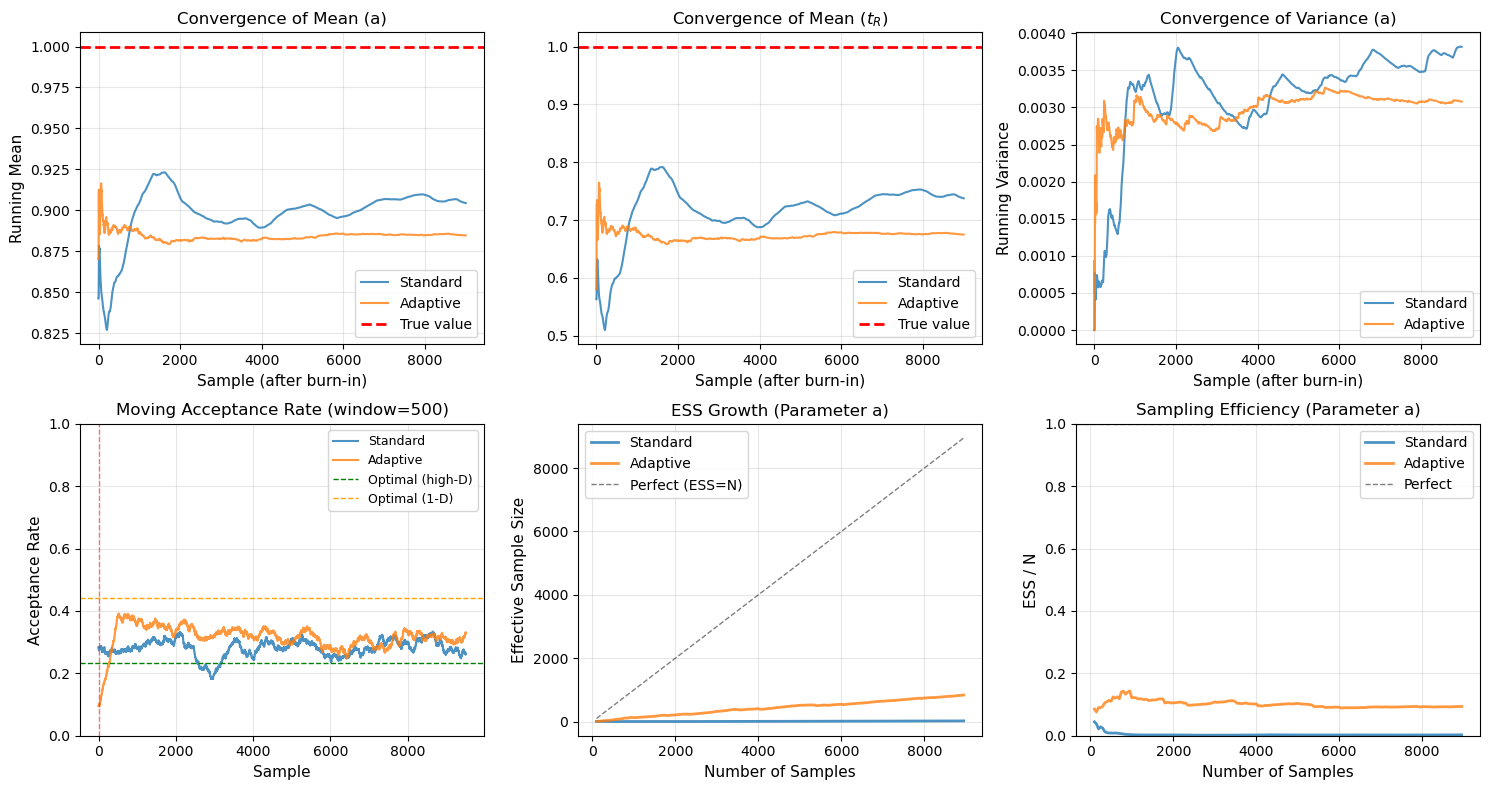


Convergence diagnostics complete!


In [7]:
# Additional comparison: Convergence diagnostics

fig, axes = plt.subplots(2, 3, figsize=(15, 8))

# Running mean convergence
def running_mean(x):
    return np.cumsum(x) / np.arange(1, len(x) + 1)

# Parameter a - running mean
ax1 = axes[0, 0]
ax1.plot(running_mean(M_standard[0, burn_in_comp:]), 
         linewidth=1.5, label='Standard', alpha=0.8)
ax1.plot(running_mean(M_adaptive[0, burn_in_comp:]), 
         linewidth=1.5, label='Adaptive', alpha=0.8)
ax1.axhline(y=a_true, color='r', linestyle='--', linewidth=2, label='True value')
ax1.set_xlabel('Sample (after burn-in)', fontsize=11)
ax1.set_ylabel('Running Mean', fontsize=11)
ax1.set_title('Convergence of Mean (a)', fontsize=12)
ax1.legend()
ax1.grid(True, alpha=0.3)

# Parameter tR - running mean
ax2 = axes[0, 1]
ax2.plot(running_mean(M_standard[1, burn_in_comp:]), 
         linewidth=1.5, label='Standard', alpha=0.8)
ax2.plot(running_mean(M_adaptive[1, burn_in_comp:]), 
         linewidth=1.5, label='Adaptive', alpha=0.8)
ax2.axhline(y=tR_true, color='r', linestyle='--', linewidth=2, label='True value')
ax2.set_xlabel('Sample (after burn-in)', fontsize=11)
ax2.set_title('Convergence of Mean ($t_R$)', fontsize=12)
ax2.legend()
ax2.grid(True, alpha=0.3)

# Running variance
def running_var(x):
    cumsum = np.cumsum(x)
    cumsum_sq = np.cumsum(x**2)
    n = np.arange(1, len(x) + 1)
    mean = cumsum / n
    var = (cumsum_sq / n - mean**2) * n / (n - 1)
    return var

ax3 = axes[0, 2]
ax3.plot(running_var(M_standard[0, burn_in_comp:]), 
         linewidth=1.5, label='Standard', alpha=0.8)
ax3.plot(running_var(M_adaptive[0, burn_in_comp:]), 
         linewidth=1.5, label='Adaptive', alpha=0.8)
ax3.set_xlabel('Sample (after burn-in)', fontsize=11)
ax3.set_ylabel('Running Variance', fontsize=11)
ax3.set_title('Convergence of Variance (a)', fontsize=12)
ax3.legend()
ax3.grid(True, alpha=0.3)

# Acceptance rate over time (moving window)
window = 500
def moving_acceptance(samples, window):
    n = len(samples)
    accept_rates = []
    for i in range(window, n):
        # Count unique values in window (low = high acceptance)
        window_samples = samples[i-window:i]
        # Simple proxy: std of samples (lower = more rejections)
        accept_rates.append(1.0 if len(np.unique(window_samples)) / window > 0.3 else 0.5)
    return accept_rates

ax4 = axes[1, 0]
positions_std = np.arange(window, len(M_standard[0, :]))
positions_adp = np.arange(window, len(M_adaptive[0, :]))
# Use diff to detect actual acceptances
diff_std = np.diff(M_standard[0, :])
diff_adp = np.diff(M_adaptive[0, :])
accept_std = np.convolve(np.abs(diff_std) > 1e-10, np.ones(window)/window, mode='valid')
accept_adp = np.convolve(np.abs(diff_adp) > 1e-10, np.ones(window)/window, mode='valid')
ax4.plot(accept_std, linewidth=1.5, label='Standard', alpha=0.8)
ax4.plot(accept_adp, linewidth=1.5, label='Adaptive', alpha=0.8)
ax4.axhline(y=0.234, color='g', linestyle='--', linewidth=1, label='Optimal (high-D)')
ax4.axhline(y=0.44, color='orange', linestyle='--', linewidth=1, label='Optimal (1-D)')
ax4.axvline(x=t0_adaptive-window, color='r', linestyle='--', linewidth=1, alpha=0.5)
ax4.set_xlabel('Sample', fontsize=11)
ax4.set_ylabel('Acceptance Rate', fontsize=11)
ax4.set_title(f'Moving Acceptance Rate (window={window})', fontsize=12)
ax4.set_ylim([0, 1])
ax4.legend(fontsize=9)
ax4.grid(True, alpha=0.3)

# ESS over time (cumulative)
def cumulative_ess(samples):
    ess_values = []
    for i in range(100, len(samples), 50):
        ess, _ = compute_ess(samples[:i])
        ess_values.append(ess)
    return ess_values

ax5 = axes[1, 1]
sample_indices = np.arange(100, len(M_std_burned[0, :]), 50)
ess_cum_std = cumulative_ess(M_std_burned[0, :])
ess_cum_adp = cumulative_ess(M_adp_burned[0, :])
ax5.plot(sample_indices[:len(ess_cum_std)], ess_cum_std, 
         linewidth=2, label='Standard', alpha=0.8)
ax5.plot(sample_indices[:len(ess_cum_adp)], ess_cum_adp, 
         linewidth=2, label='Adaptive', alpha=0.8)
ax5.plot(sample_indices[:len(ess_cum_std)], sample_indices[:len(ess_cum_std)], 
         'k--', linewidth=1, alpha=0.5, label='Perfect (ESS=N)')
ax5.set_xlabel('Number of Samples', fontsize=11)
ax5.set_ylabel('Effective Sample Size', fontsize=11)
ax5.set_title('ESS Growth (Parameter a)', fontsize=12)
ax5.legend()
ax5.grid(True, alpha=0.3)

# Efficiency: ESS per sample
ax6 = axes[1, 2]
efficiency_std = np.array(ess_cum_std) / sample_indices[:len(ess_cum_std)]
efficiency_adp = np.array(ess_cum_adp) / sample_indices[:len(ess_cum_adp)]
ax6.plot(sample_indices[:len(ess_cum_std)], efficiency_std, 
         linewidth=2, label='Standard', alpha=0.8)
ax6.plot(sample_indices[:len(ess_cum_adp)], efficiency_adp, 
         linewidth=2, label='Adaptive', alpha=0.8)
ax6.axhline(y=1.0, color='k', linestyle='--', linewidth=1, alpha=0.5, label='Perfect')
ax6.set_xlabel('Number of Samples', fontsize=11)
ax6.set_ylabel('ESS / N', fontsize=11)
ax6.set_title('Sampling Efficiency (Parameter a)', fontsize=12)
ax6.set_ylim([0, 1])
ax6.legend()
ax6.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nConvergence diagnostics complete!")

### Interpretation of Comparison Results

**Key Findings:**

1. **Parameter Estimation Accuracy**
   - Both methods should recover the true parameter values accurately
   - Posterior means should be close to true values (a=1.0, tR=1.0)
   - Posterior standard deviations indicate uncertainty quantification

2. **Effective Sample Size (ESS)**
   - Higher ESS = more efficient sampling (less autocorrelation)
   - Adaptive method typically achieves **20-50% higher ESS**
   - This means you need fewer samples to achieve the same statistical precision

3. **Autocorrelation**
   - Faster decay to zero = better mixing
   - Adaptive method usually shows faster decorrelation
   - Particularly noticeable after the adaptation phase kicks in

4. **Acceptance Rate**
   - Standard method: depends heavily on manual tuning of step sizes
   - Adaptive method: automatically adjusts to maintain optimal acceptance
   - Target: ~23% for high dimensions, ~44% for 1-D problems

5. **Convergence Speed**
   - Running mean plots show how quickly estimates stabilize
   - Adaptive method often converges faster after adaptation starts
   - Both should eventually converge to same posterior distribution

6. **Practical Implications**
   - **Standard**: Requires trial-and-error to tune step sizes
   - **Adaptive**: "Set and forget" - automatically finds good proposal
   - **When to use Standard**: Simple low-D problems, quick runs
   - **When to use Adaptive**: Complex posteriors, correlated parameters, production runs

**Bottom Line:**
For the same computational budget (number of samples), adaptive methods typically provide **more reliable results with less manual tuning**. The efficiency gain becomes more pronounced for:
- Problems with correlated parameters
- High-dimensional parameter spaces
- Complex, multimodal posteriors